In [1]:
# libraries
import os
import sys
import json
import numpy as np
import pandas as pd
sys.path.append(os.path.abspath('../../'))
sys.path.append(os.path.abspath('../../extra_files'))
import helper as hp
from imageio import imwrite, imread
from skimage.transform import resize

In [2]:
# File paths
data_path = '/home/aldo/Documents/data-cic/'
preprocess_path = data_path + 'preprocess_data'

## Training SSD300 trained with mobilenet backbone trained

In [3]:
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TerminateOnNaN, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model
from math import ceil
import numpy as np
from matplotlib import pyplot as plt

from light_models.keras_ssd300_mobilenetv1 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_input_encoder import SSDInputEncoder
from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.data_augmentation_chain_original_ssd import SSDDataAugmentation
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

from extra_files.f1_callback import F1_callback as f1_call

Using TensorFlow backend.
/home/aldo/Documents/ssd/data_generator/object_detection_2d_data_generator.py:43: UserWarning: 'BeautifulSoup' module is missing. The XML-parser will be unavailable.
  warnings.warn("'BeautifulSoup' module is missing. The XML-parser will be unavailable.")


### Parameters (original SSD300 architecture)

In [4]:
## Parameteres needed for ssd_300() and SSDInputEncoder()

img_height = 300 # Height of the model input images
img_width = 300 # Width of the model input images
img_channels = 3 # Number of color channels of the model input images
mean_color = [1., 1., 1.] # The per-channel mean of the images in the dataset. Do not change this value if you're using any of the pre-trained weights.
divide_by_stddev = [127.5, 127.5, 127.5]
swap_channels = False # The color channel order in the original SSD is BGR, so we'll have the model reverse the color channel order of the input images.
n_classes = 1 # Number of positive classes, e.g. 20 for Pascal VOC, 80 for MS COCO
scales_pascal = [0.1, 0.2, 0.37, 0.54, 0.71, 0.88, 1.05] # The anchor box scaling factors used in the original SSD300 for the Pascal VOC datasets
scales = scales_pascal
#scales = [0.07, 0.15, 0.33, 0.51, 0.69, 0.87, 1.05]
aspect_ratios = [[1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5, 3.0, 1.0/3.0],
                 [1.0, 2.0, 0.5],
                 [1.0, 2.0, 0.5]] # The anchor box aspect ratios used in the original SSD300; the order matters
two_boxes_for_ar1 = True
steps = [16, 30, 60, 100, 150, 300] # The space between two adjacent anchor box center points for each predictor layer.
offsets = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5] # The offsets of the first anchor box center points from the top and left borders of the image as a fraction of the step size for each predictor layer.
clip_boxes = False # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The variances by which the encoded target coordinates are divided as in the original implementation
normalize_coords = True

## Create new model with SSD weights

In [5]:
# 1: Build the Keras model.

K.clear_session() # Clear previous models from memory.

model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=0.75,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

# 2: Load some weights into the model.

# TODO: Set the path to the weights you want to load.
#weights_path = '/home/aldo/Documents/weights/classifiers/mobilenetv1_alpha_0.75.h5'
#weights_path = '/home/aldo/Downloads/ssd300_mobilenetv1_imagenet_cic.h5'
#model.load_weights(weights_path, by_name=True)

# 3: Instantiate an optimizer and the SSD loss function and compile the model.
#    If you want to follow the original Caffe implementation, use the preset SGD
#    optimizer, otherwise I'd recommend the commented-out Adam optimizer.

adam = Adam(lr=0.001)
#sgd = SGD(lr=0.001, momentum=0.9, decay=0.0, nesterov=False)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

In [6]:
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 300, 300, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 300, 300, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 300, 300, 3)  0           input_stddev_normalization[0][0] 
__________________________________________________________________________________________________
model_1 (M

## Data generator for the training

In [6]:
# 1: Instantiate two `DataGenerator` objects: One for training, one for validation.

# Optional: If you have enough memory, consider loading the images into memory for the reasons explained above.

train_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)
val_dataset = DataGenerator(load_images_into_memory=True, hdf5_dataset_path=None)

# 2: Parse the image and label lists for the training and validation datasets.

# TODO: Set the paths to your dataset here.

# Images
images_dir = data_path + 'images_reduced'

# Ground truth
#train_labels_filename = preprocess_path + '/cic_train_reduced.csv'
train_labels_filename = preprocess_path + '/cic_train_val_reduced.csv'
val_labels_filename   = preprocess_path + '/cic_val_reduced.csv'

train_dataset.parse_csv(images_dir=images_dir,
                        labels_filename=train_labels_filename,
                        input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], # This is the order of the first six columns in the CSV file that contains the labels for your dataset. If your labels are in XML format, maybe the XML parser will be helpful, check the documentation.
                        include_classes='all')

val_dataset.parse_csv(images_dir=images_dir,
                      labels_filename=val_labels_filename,
                      input_format=['image_name', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'],
                      include_classes='all')

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Loading images into memory: 100%|██████████| 45/45 [00:00<00:00, 167.43it/s]
Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


In [7]:
# 3: Set the batch size.
batch_size = 32 # Change the batch size if you like, or if you run into GPU memory issues.

# 4: Set the image transformations for pre-processing and data augmentation options.
# For the training generator:
ssd_data_augmentation = SSDDataAugmentation(img_height=img_height,
                                            img_width=img_width,
                                            background=(0, 0, 0))

# For the validation generator:
convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

# 5: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function.
# The encoder constructor needs the spatial dimensions of the model's predictor layers to create the anchor boxes.
predictor_sizes = [model.get_layer('conv11_mbox_conf').output_shape[1:3],
                   model.get_layer('conv13_mbox_conf').output_shape[1:3],
                   model.get_layer('conv14_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv15_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv16_2_mbox_conf').output_shape[1:3],
                   model.get_layer('conv17_2_mbox_conf').output_shape[1:3]]

ssd_input_encoder = SSDInputEncoder(img_height=img_height,
                                    img_width=img_width,
                                    n_classes=n_classes,
                                    predictor_sizes=predictor_sizes,
                                    scales=scales,
                                    aspect_ratios_per_layer=aspect_ratios,
                                    two_boxes_for_ar1=two_boxes_for_ar1,
                                    steps=steps,
                                    offsets=offsets,
                                    clip_boxes=clip_boxes,
                                    variances=variances,
                                    matching_type='multi',
                                    pos_iou_threshold=0.5,
                                    neg_iou_limit=0.5,
                                    normalize_coords=normalize_coords)

# 6: Create the generator handles that will be passed to Keras' `fit_generator()` function.
train_generator = train_dataset.generate(batch_size=batch_size,
                                         shuffle=True,
                                         transformations=[ssd_data_augmentation],
                                         #transformations=[convert_to_3_channels,
                                                          #resize],
                                         label_encoder=ssd_input_encoder,
                                         returns={'processed_images',
                                                  'encoded_labels'},
                                         keep_images_without_gt=False)

val_generator = val_dataset.generate(batch_size=batch_size,
                                     shuffle=False,
                                     transformations=[convert_to_3_channels,
                                                      resize],
                                     label_encoder=ssd_input_encoder,
                                     returns={'processed_images',
                                              'encoded_labels'},
                                     keep_images_without_gt=False)

# Get the number of samples in the training and validations datasets.
train_dataset_size = train_dataset.get_dataset_size()
val_dataset_size   = val_dataset.get_dataset_size()

print("Number of images in the training dataset:\t{:>6}".format(train_dataset_size))
print("Number of images in the validation dataset:\t{:>6}".format(val_dataset_size))

Number of images in the training dataset:	   255
Number of images in the validation dataset:	    45


## Remaining training parameters

In [8]:
# Define a learning rate schedule.
def lr_schedule(epoch):
    if epoch < 400:
        return 0.001
    else:
        return 0.0001

In [9]:
lr_list = [0.01, 0.001, 0.0001]

for lr in lr_list:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH LEARNING RATE:', lr)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=0.75,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=lr)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/mobilenet_v1_alpha_0.75.h5')
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Downloads/cic_mobilenetv1/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'model_' + str(lr) + '.csv',
                           separator=',',
                           append=True)


    f1_callback = f1_call(0.20, 
                           0.45, 
                           200, 
                           normalize_coords, 
                           img_height, 
                           img_width, 
                           (1, 2006, 14),
                           main_path + 'f1_' + str(lr) + '.csv',
                           main_path + 'model.h5',
                           label_csv='/home/aldo/Documents/data-cic/preprocess_data/cic_val.csv',
                           path_img='/home/aldo/Documents/data-cic/images',
                           verborse=True)


    callbacks = [csv_logger,
                 f1_callback]
    
    initial_epoch   = 0
    final_epoch     = 100
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  validation_data=val_generator,
                                  validation_steps=ceil(val_dataset_size/batch_size),
                                  initial_epoch=initial_epoch)

TRAINING MODEL WITH LEARNING RATE: 0.01
Epoch 1/100
15/15 [==============================] - 14s 926ms/step - loss: 4.8947 - val_loss: 5.3526
Number of images: 45
Presicion: 0.1146
Recall: 0.4904
F1 score: 0.1858
F1 score: 0.18577770984230269
Improve F1 score from -inf to 0.18577770984230269
Epoch 2/100
15/15 [==============================] - 5s 320ms/step - loss: 4.8155 - val_loss: 6.0519
Number of images: 45
Presicion: 0.085
Recall: 0.3256
F1 score: 0.1348
F1 score: 0.13479185347894207
Epoch 3/100
15/15 [==============================] - 7s 443ms/step - loss: 4.5740 - val_loss: 5.6612
Number of images: 45
Presicion: 0.1876
Recall: 0.3584
F1 score: 0.2463
F1 score: 0.24630657065699652
Improve F1 score from 0.18577770984230269 to 0.24630657065699652
Epoch 4/100
15/15 [==============================] - 8s 525ms/step - loss: 4.3355 - val_loss: 5.4237
Number of images: 45
Presicion: 0.1918
Recall: 0.2217
F1 score: 0.2057
F1 score: 0.20567026549210243
Epoch 5/100
15/15 [==================

Number of images: 45
Presicion: 0.0601
Recall: 0.1016
F1 score: 0.0755
F1 score: 0.07549819238613302
Epoch 40/100
15/15 [==============================] - 8s 540ms/step - loss: 9.1444 - val_loss: 204.3024
Number of images: 45
Presicion: 0.0012
Recall: 0.0262
F1 score: 0.0023
F1 score: 0.0022739453522883247
Epoch 41/100
15/15 [==============================] - 8s 561ms/step - loss: 7.9940 - val_loss: 319.5514


/home/aldo/Documents/ssd/bounding_box_utils/bounding_box_utils.py:383: RuntimeWarning: invalid value encountered in true_divide
  return intersection_areas / union_areas
/home/aldo/Documents/ssd/ssd_encoder_decoder/ssd_output_decoder.py:91: RuntimeWarning: invalid value encountered in less_equal
  boxes_left = boxes_left[similarities <= iou_threshold] # ...so that we can remove the ones that overlap too much with the maximum box


Number of images: 45
Presicion: 0.0002
Recall: 0.0146
F1 score: 0.0004
F1 score: 0.0004467005038860258
Epoch 42/100
15/15 [==============================] - 7s 467ms/step - loss: 6.6959 - val_loss: 136.6003
Number of images: 45
Presicion: 0.0099
Recall: 0.1786
F1 score: 0.0188
F1 score: 0.018767682375568695
Epoch 43/100
15/15 [==============================] - 8s 506ms/step - loss: 6.3378 - val_loss: 7.1850
Number of images: 45
Presicion: 0.0432
Recall: 0.1901
F1 score: 0.0704
F1 score: 0.07035972219673368
Epoch 44/100
15/15 [==============================] - 8s 520ms/step - loss: 6.1664 - val_loss: 17.7451
Number of images: 45
Presicion: 0.0
Recall: 0.0
F1 score: 0.0
F1 score: 0.0
Epoch 45/100
15/15 [==============================] - 8s 513ms/step - loss: 6.2140 - val_loss: 11.5622
Number of images: 45
Presicion: 0.0434
Recall: 0.1896
F1 score: 0.0707
F1 score: 0.07066975912926504
Epoch 46/100
15/15 [==============================] - 8s 553ms/step - loss: 6.0102 - val_loss: 6.1821
Num

15/15 [==============================] - 7s 452ms/step - loss: 5.6252 - val_loss: 5.4305
Number of images: 45
Presicion: 0.0431
Recall: 0.4664
F1 score: 0.0789
F1 score: 0.07894191780229129
Epoch 83/100
15/15 [==============================] - 7s 437ms/step - loss: 5.5042 - val_loss: 5.3593
Number of images: 45
Presicion: 0.0478
Recall: 0.4687
F1 score: 0.0868
F1 score: 0.08676643908855654
Epoch 84/100
15/15 [==============================] - 6s 399ms/step - loss: 5.4526 - val_loss: 5.4478
Number of images: 45
Presicion: 0.0465
Recall: 0.4697
F1 score: 0.0846
F1 score: 0.08457435463842372
Epoch 85/100
15/15 [==============================] - 7s 484ms/step - loss: 5.5147 - val_loss: 5.4855
Number of images: 45
Presicion: 0.048
Recall: 0.4665
F1 score: 0.0871
F1 score: 0.08710489251818512
Epoch 86/100
15/15 [==============================] - 6s 432ms/step - loss: 5.4475 - val_loss: 5.4032
Number of images: 45
Presicion: 0.0512
Recall: 0.5101
F1 score: 0.0931
F1 score: 0.09309123137045298

15/15 [==============================] - 8s 544ms/step - loss: 2.9399 - val_loss: 2.9063
Number of images: 45
Presicion: 0.5912
Recall: 0.6101
F1 score: 0.6005
F1 score: 0.600528157140293
Epoch 21/100
15/15 [==============================] - 8s 520ms/step - loss: 2.8915 - val_loss: 2.8981
Number of images: 45
Presicion: 0.6708
Recall: 0.5525
F1 score: 0.6059
F1 score: 0.605925526546933
Epoch 22/100
15/15 [==============================] - 8s 503ms/step - loss: 2.7974 - val_loss: 2.9072
Number of images: 45
Presicion: 0.5828
Recall: 0.583
F1 score: 0.5829
F1 score: 0.5829137048633772
Epoch 23/100
15/15 [==============================] - 7s 489ms/step - loss: 2.7897 - val_loss: 2.8567
Number of images: 45
Presicion: 0.5925
Recall: 0.5855
F1 score: 0.589
F1 score: 0.588981651496422
Epoch 24/100
15/15 [==============================] - 8s 528ms/step - loss: 2.9318 - val_loss: 2.8943
Number of images: 45
Presicion: 0.6025
Recall: 0.5803
F1 score: 0.5912
F1 score: 0.5911704501110348
Epoch 25

Epoch 60/100
15/15 [==============================] - 7s 495ms/step - loss: 2.4184 - val_loss: 2.7327
Number of images: 45
Presicion: 0.6422
Recall: 0.6186
F1 score: 0.6302
F1 score: 0.6302235928119861
Epoch 61/100
15/15 [==============================] - 7s 475ms/step - loss: 2.6045 - val_loss: 2.7516
Number of images: 45
Presicion: 0.6642
Recall: 0.5984
F1 score: 0.6296
F1 score: 0.629563316888682
Epoch 62/100
15/15 [==============================] - 7s 500ms/step - loss: 2.6340 - val_loss: 2.8802
Number of images: 45
Presicion: 0.6613
Recall: 0.6034
F1 score: 0.6311
F1 score: 0.6310536509608025
Epoch 63/100
15/15 [==============================] - 7s 490ms/step - loss: 2.5200 - val_loss: 2.8074
Number of images: 45
Presicion: 0.6559
Recall: 0.6073
F1 score: 0.6306
F1 score: 0.6306430896637828
Epoch 64/100
15/15 [==============================] - 8s 510ms/step - loss: 2.5772 - val_loss: 2.7636
Number of images: 45
Presicion: 0.6597
Recall: 0.6227
F1 score: 0.6407
F1 score: 0.64065330

15/15 [==============================] - 8s 502ms/step - loss: 2.3444 - val_loss: 2.7255
Number of images: 45
Presicion: 0.6734
Recall: 0.6119
F1 score: 0.6412
F1 score: 0.641183111955721
TRAINING MODEL WITH LEARNING RATE: 0.0001
Epoch 1/100
15/15 [==============================] - 11s 758ms/step - loss: 4.0332 - val_loss: 4.0699
Number of images: 45
Presicion: 0.5356
Recall: 0.4041
F1 score: 0.4607
F1 score: 0.4606506458550852
Improve F1 score from -inf to 0.4606506458550852
Epoch 2/100
15/15 [==============================] - 5s 308ms/step - loss: 4.0574 - val_loss: 3.9848
Number of images: 45
Presicion: 0.5326
Recall: 0.4235
F1 score: 0.4718
F1 score: 0.4717908575619247
Improve F1 score from 0.4606506458550852 to 0.4717908575619247
Epoch 3/100
15/15 [==============================] - 7s 455ms/step - loss: 3.8033 - val_loss: 3.9257
Number of images: 45
Presicion: 0.5283
Recall: 0.4293
F1 score: 0.4737
F1 score: 0.473691642595832
Improve F1 score from 0.4717908575619247 to 0.473691642

Number of images: 45
Presicion: 0.601
Recall: 0.5162
F1 score: 0.5554
F1 score: 0.5553755394098991
Improve F1 score from 0.5530810825525673 to 0.5553755394098991
Epoch 34/100
15/15 [==============================] - 8s 515ms/step - loss: 3.4563 - val_loss: 3.2860
Number of images: 45
Presicion: 0.608
Recall: 0.5168
F1 score: 0.5587
F1 score: 0.5587264170700955
Improve F1 score from 0.5553755394098991 to 0.5587264170700955
Epoch 35/100
15/15 [==============================] - 8s 515ms/step - loss: 3.3912 - val_loss: 3.2804
Number of images: 45
Presicion: 0.6119
Recall: 0.5154
F1 score: 0.5595
F1 score: 0.5594955513009137
Improve F1 score from 0.5587264170700955 to 0.5594955513009137
Epoch 36/100
15/15 [==============================] - 8s 501ms/step - loss: 3.2438 - val_loss: 3.2796
Number of images: 45
Presicion: 0.5899
Recall: 0.514
F1 score: 0.5493
F1 score: 0.5493010360195874
Epoch 37/100
15/15 [==============================] - 8s 501ms/step - loss: 3.3666 - val_loss: 3.2691
Number

15/15 [==============================] - 8s 528ms/step - loss: 3.0720 - val_loss: 3.0311
Number of images: 45
Presicion: 0.6037
Recall: 0.577
F1 score: 0.5901
F1 score: 0.5900824577093199
Epoch 71/100
15/15 [==============================] - 8s 522ms/step - loss: 3.1236 - val_loss: 3.0344
Number of images: 45
Presicion: 0.6156
Recall: 0.5773
F1 score: 0.5958
F1 score: 0.5958064689506022
Improve F1 score from 0.592799185988441 to 0.5958064689506022
Epoch 72/100
15/15 [==============================] - 8s 524ms/step - loss: 3.1584 - val_loss: 3.0349
Number of images: 45
Presicion: 0.6258
Recall: 0.5761
F1 score: 0.5999
F1 score: 0.5999351552851806
Improve F1 score from 0.5958064689506022 to 0.5999351552851806
Epoch 73/100
15/15 [==============================] - 8s 511ms/step - loss: 3.0175 - val_loss: 3.0331
Number of images: 45
Presicion: 0.6213
Recall: 0.5744
F1 score: 0.597
F1 score: 0.5969533289645025
Epoch 74/100
15/15 [==============================] - 8s 507ms/step - loss: 3.0890

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
main_path = '/home/aldo/Downloads/cic_mobilenetv1/'


mob_01 = pd.read_csv(main_path + 'model_0.01.csv')
mob_001 = pd.read_csv(main_path + 'model_0.001.csv')
mob_0001 = pd.read_csv(main_path + 'model_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01['epoch'][10:], mob_01['val_loss'][10:], color='r')
ax.plot(mob_001['epoch'][10:], mob_001['val_loss'][10:], color='b')
ax.plot(mob_0001['epoch'][10:], mob_0001['val_loss'][10:], color='g')

IndentationError: unexpected indent (<ipython-input-10-bedfd3aa7317>, line 3)

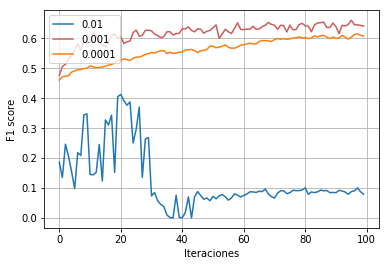

In [14]:
mob_01_f1 = pd.read_csv(main_path + 'f1_0.01.csv')
mob_001_f1 = pd.read_csv(main_path + 'f1_0.001.csv')
mob_0001_f1 = pd.read_csv(main_path + 'f1_0.0001.csv')

fig, ax = plt.subplots()
ax.plot(mob_01_f1['epoch'], mob_01_f1['f1 score'], label='0.01')
ax.plot(mob_001_f1['epoch'], mob_001_f1['f1 score'], color='indianred', label='0.001')
ax.plot(mob_0001_f1['epoch'], mob_0001_f1['f1 score'], label='0.0001')

plt.grid(True)
plt.xlabel('Iteraciones')
plt.ylabel('F1 score')
plt.legend(loc='upper left')
plt.savefig('mejor_tasa.pdf')

In [9]:
alphas = [0.75]

for alpha in alphas:
    # 1: Build the Keras model.
    K.clear_session() # Clear previous models from memory.

    print('TRAINING MODEL WITH ALPHA:', alpha)
    
    model = ssd_300(image_size=(img_height, img_width, img_channels),
                n_classes=n_classes,
                mode='training',
                alpha=alpha,
                scales=scales,
                aspect_ratios_per_layer=aspect_ratios,
                two_boxes_for_ar1=two_boxes_for_ar1,
                steps=steps,
                offsets=offsets,
                clip_boxes=clip_boxes,
                variances=variances,
                normalize_coords=normalize_coords,
                subtract_mean=mean_color,
                divide_by_stddev=divide_by_stddev,
                swap_channels=swap_channels)

    adam = Adam(lr=0.001)
    ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)
    model.load_weights('/home/aldo/Documents/weights/light_models/PASCAL/mobilenet_v1_alpha_0.75.h5')
    model.compile(optimizer=adam, loss=ssd_loss.compute_loss)
    
    # Define model callbacks.
    main_path = '/home/aldo/Documents/'
    # TODO: Set the filepath under which you want to save the model.

    csv_logger = CSVLogger(filename=main_path + 'data-cic/history/light_models/CIC/mobilenet_v1_alpha_' + str(alpha) + '.csv',
                           separator=',',
                           append=True)

    learning_rate_scheduler = LearningRateScheduler(schedule=lr_schedule, verbose=1)


    callbacks = [csv_logger,
                 learning_rate_scheduler]
    
    initial_epoch   = 0
    final_epoch     = 500
    steps_per_epoch = 15

    history = model.fit_generator(generator=train_generator,
                                  steps_per_epoch=steps_per_epoch,
                                  epochs=final_epoch,
                                  callbacks=callbacks,
                                  initial_epoch=initial_epoch)
    
    model.save(main_path + 'weights/light_models/CIC/mobilenet_v1_alpha_' + str(alpha) + '.h5')

TRAINING MODEL WITH ALPHA: 0.75
Epoch 1/500

Epoch 00001: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 14s 903ms/step - loss: 4.0094
Epoch 2/500

Epoch 00002: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 9s 629ms/step - loss: 3.5820
Epoch 3/500

Epoch 00003: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 744ms/step - loss: 3.5062
Epoch 4/500

Epoch 00004: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 741ms/step - loss: 3.4926
Epoch 5/500

Epoch 00005: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 3.3584
Epoch 6/500

Epoch 00006: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 743ms/step - loss: 3.2046
Epoch 7/500

Epoch 00007: LearningRateScheduler setting learnin

15/15 [==============================] - 11s 744ms/step - loss: 2.5483
Epoch 55/500

Epoch 00055: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 802ms/step - loss: 2.5782
Epoch 56/500

Epoch 00056: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 702ms/step - loss: 2.6034
Epoch 57/500

Epoch 00057: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 756ms/step - loss: 2.6443
Epoch 58/500

Epoch 00058: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 12s 798ms/step - loss: 2.5924
Epoch 59/500

Epoch 00059: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 707ms/step - loss: 2.4665
Epoch 60/500

Epoch 00060: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 732ms/step - loss: 2.4602
Epoch 61/500

Epo

15/15 [==============================] - 11s 708ms/step - loss: 2.3922
Epoch 109/500

Epoch 00109: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 2.3172
Epoch 110/500

Epoch 00110: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 668ms/step - loss: 2.3398
Epoch 111/500

Epoch 00111: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 671ms/step - loss: 2.1519
Epoch 112/500

Epoch 00112: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 690ms/step - loss: 2.2554
Epoch 113/500

Epoch 00113: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 691ms/step - loss: 2.4054
Epoch 114/500

Epoch 00114: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 685ms/step - loss: 2.2453
Epoch 115/5

15/15 [==============================] - 10s 671ms/step - loss: 2.0790
Epoch 163/500

Epoch 00163: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 696ms/step - loss: 2.1181
Epoch 164/500

Epoch 00164: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 649ms/step - loss: 2.0680
Epoch 165/500

Epoch 00165: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 656ms/step - loss: 2.0743
Epoch 166/500

Epoch 00166: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 672ms/step - loss: 2.1771
Epoch 167/500

Epoch 00167: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 673ms/step - loss: 2.0965
Epoch 168/500

Epoch 00168: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 687ms/step - loss: 2.2306
Epoch 169/5

15/15 [==============================] - 10s 686ms/step - loss: 1.9761
Epoch 217/500

Epoch 00217: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 681ms/step - loss: 2.1133
Epoch 218/500

Epoch 00218: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 661ms/step - loss: 2.0647
Epoch 219/500

Epoch 00219: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 671ms/step - loss: 1.9949
Epoch 220/500

Epoch 00220: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 719ms/step - loss: 1.9535
Epoch 221/500

Epoch 00221: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 723ms/step - loss: 2.0465
Epoch 222/500

Epoch 00222: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 699ms/step - loss: 2.1565
Epoch 223/5

15/15 [==============================] - 11s 721ms/step - loss: 2.0214
Epoch 271/500

Epoch 00271: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 686ms/step - loss: 1.8783
Epoch 272/500

Epoch 00272: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 682ms/step - loss: 1.9524
Epoch 273/500

Epoch 00273: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 695ms/step - loss: 1.9722
Epoch 274/500

Epoch 00274: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 657ms/step - loss: 1.9086
Epoch 275/500

Epoch 00275: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 690ms/step - loss: 1.9772
Epoch 276/500

Epoch 00276: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 693ms/step - loss: 2.0456
Epoch 277/5

15/15 [==============================] - 11s 714ms/step - loss: 1.8284
Epoch 325/500

Epoch 00325: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 655ms/step - loss: 1.8456
Epoch 326/500

Epoch 00326: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 714ms/step - loss: 1.9500
Epoch 327/500

Epoch 00327: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 684ms/step - loss: 1.8809
Epoch 328/500

Epoch 00328: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 705ms/step - loss: 1.7523
Epoch 329/500

Epoch 00329: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 707ms/step - loss: 1.9212
Epoch 330/500

Epoch 00330: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 692ms/step - loss: 1.8086
Epoch 331/5

15/15 [==============================] - 10s 691ms/step - loss: 1.7549
Epoch 379/500

Epoch 00379: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 690ms/step - loss: 1.8658
Epoch 380/500

Epoch 00380: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 679ms/step - loss: 1.8214
Epoch 381/500

Epoch 00381: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 707ms/step - loss: 1.9098
Epoch 382/500

Epoch 00382: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 11s 704ms/step - loss: 1.8579
Epoch 383/500

Epoch 00383: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 670ms/step - loss: 1.7618
Epoch 384/500

Epoch 00384: LearningRateScheduler setting learning rate to 0.001.
15/15 [==============================] - 10s 697ms/step - loss: 1.8488
Epoch 385/5

15/15 [==============================] - 10s 689ms/step - loss: 1.6908
Epoch 432/500

Epoch 00432: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 691ms/step - loss: 1.7198
Epoch 433/500

Epoch 00433: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 697ms/step - loss: 1.6115
Epoch 434/500

Epoch 00434: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 687ms/step - loss: 1.7215
Epoch 435/500

Epoch 00435: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 683ms/step - loss: 1.6329
Epoch 436/500

Epoch 00436: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 712ms/step - loss: 1.7143
Epoch 437/500

Epoch 00437: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 671ms/step - loss: 1.6534
Epoch

15/15 [==============================] - 11s 709ms/step - loss: 1.5686
Epoch 485/500

Epoch 00485: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 11s 716ms/step - loss: 1.6535
Epoch 486/500

Epoch 00486: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 685ms/step - loss: 1.6797
Epoch 487/500

Epoch 00487: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 676ms/step - loss: 1.5901
Epoch 488/500

Epoch 00488: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 678ms/step - loss: 1.6302
Epoch 489/500

Epoch 00489: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 682ms/step - loss: 1.8098
Epoch 490/500

Epoch 00490: LearningRateScheduler setting learning rate to 0.0001.
15/15 [==============================] - 10s 675ms/step - loss: 1.6198
Epoch